# ARIMA

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/2yrs_data.csv')

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = MinMaxScaler(feature_range=(0, 1))
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])

df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)

df.head(5)

,Hour,is_weekend,is_holiday,Day,Month,Year,hourly_active_power
0,17,1,0,16,12,2006,0.378494
1,18,1,0,16,12,2006,0.551144
2,19,1,0,16,12,2006,0.514685
3,20,1,0,16,12,2006,0.493991
4,21,1,0,16,12,2006,0.460654


In [ ]:
train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target ##
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target ##

In [2]:
# Load data
df = pd.read_csv('2yrs_data.csv')

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract datetime features
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

# Aggregate data to hourly sums
df_hourly = df.groupby(['Year', 'Month', 'Day', 'Hour']).agg({'Global_active_power': 'sum'}).reset_index()

# Create 'DateTime' column from 'Year','Month','Day','Hour'
df_hourly['DateTime'] = pd.to_datetime(df_hourly[['Year', 'Month', 'Day', 'Hour']])

# Set 'DateTime' as index
df_hourly = df_hourly.set_index('DateTime')

# Scale 'Global_active_power'
scaler = StandardScaler()
df_hourly['hourly_active_power'] = scaler.fit_transform(df_hourly[['Global_active_power']])

# Drop unnecessary columns
df_hourly = df_hourly.drop(columns=['Global_active_power', 'Year', 'Month', 'Day', 'Hour'])

# Split data into train and test sets
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]

# Forward fill missing data
train = train.reindex(pd.date_range(start=train.index.min(), end=train.index.max(), freq='h'))
train = train.ffill()
test = test.reindex(pd.date_range(start=test.index.min(), end=test.index.max(), freq='h'))
test = test.ffill()

y_train = train['hourly_active_power']
y_test = test['hourly_active_power']

In [28]:
# Fit the ARIMA model
model = ARIMA(y_train, order=(1, 0, 4), seasonal_order=(1,0,1,24*3))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                hourly_active_power   No. Observations:                14341
Model:             ARIMA(1, 0, 4)x(1, 0, [1], 72)   Log Likelihood              -14079.563
Date:                            Thu, 05 Dec 2024   AIC                          28177.126
Time:                                    00:44:35   BIC                          28245.264
Sample:                                12-16-2006   HQIC                         28199.784
                                     - 08-05-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1219      0.176      0.693      0.488      -0.223       0.467
ar.L1          0.9766      0.004   

In [ ]:
# Forecast values
n_periods = len(y_test)
forecast = model_fit.forecast(steps=n_periods)

# Convert forecast to pandas Series
forecast_series = pd.Series(forecast, index=y_test.index)

# Evaluate the forecast against y_test on scaled data
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
print(f'RMSE (scaled data): {rmse}')
print(f'MAE (scaled data): {mae}')
print(f'R-squared (scaled data): {r2}')

RMSE (scaled data): 0.8688142560623812
MAE (scaled data): 0.6648360765435163


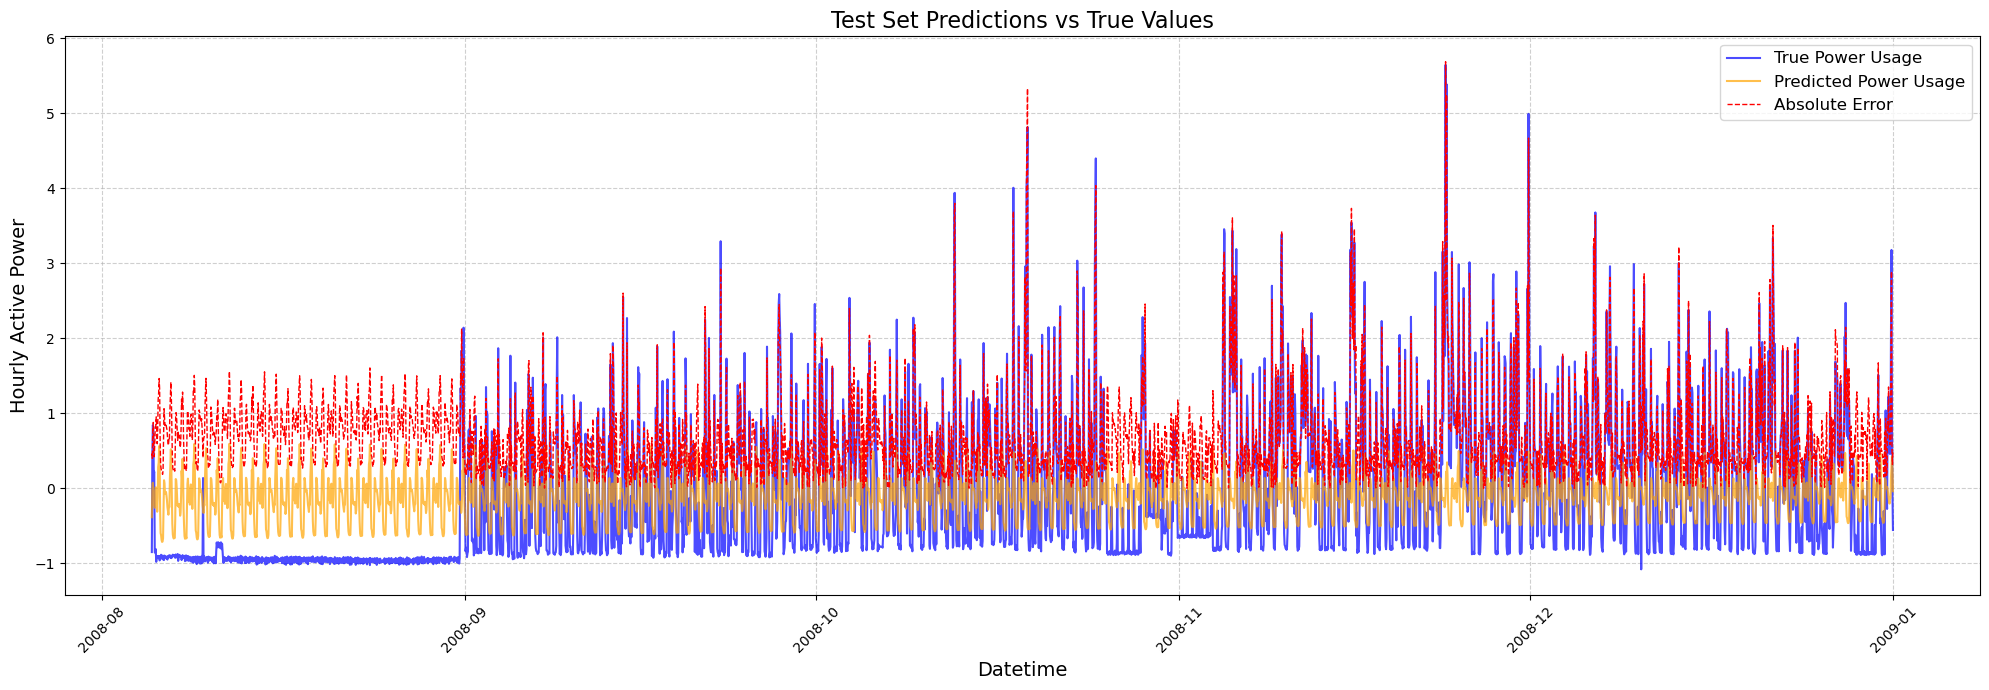

In [30]:
# Extract data for visualization (aligning with friend's variable names)
test_labels_1d = y_test.values  # True values
test_predictions_1d = forecast_series.values  # Predicted values
datetime_test = y_test.index  # Timestamps

# Calculate absolute error
absolute_error = np.abs(test_labels_1d - test_predictions_1d)

# Plot using friend's style
plt.figure(figsize=(20, 7))

# Plot each data type
line1, = plt.plot(datetime_test, test_labels_1d, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
line2, = plt.plot(datetime_test, test_predictions_1d, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
line3, = plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)

# Add a single legend
plt.legend(handles=[line1, line2, line3], fontsize=12, loc='upper right')

# Add labels, title, and grid
plt.title('Test Set Predictions vs True Values', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


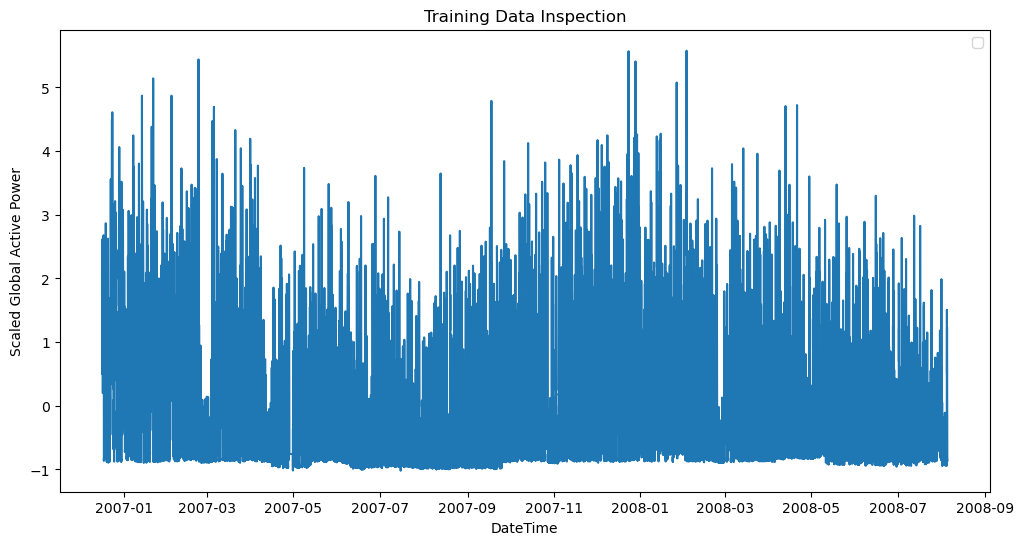

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train)
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Scaled Global Active Power')
plt.title('Training Data Inspection')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


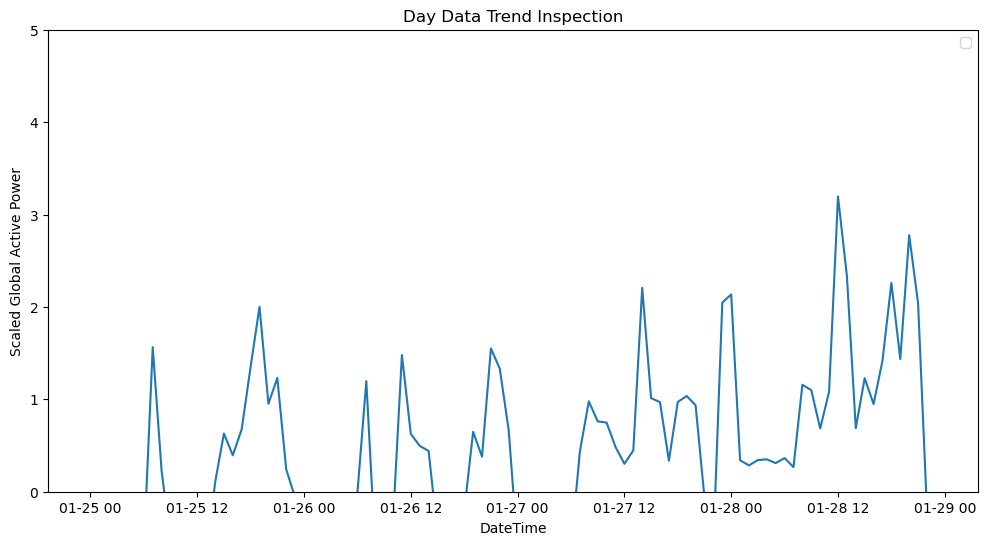

In [26]:
data_temp = y_train['2007-01-25 00:00:00':'2007-01-28 23:00:00']

plt.figure(figsize=(12, 6))
plt.plot(data_temp.index, data_temp)
plt.legend()
plt.xlabel('DateTime')
plt.ylim(0, 5)
plt.ylabel('Scaled Global Active Power')
plt.title('Day Data Trend Inspection')
plt.show()

<Figure size 1400x600 with 0 Axes>

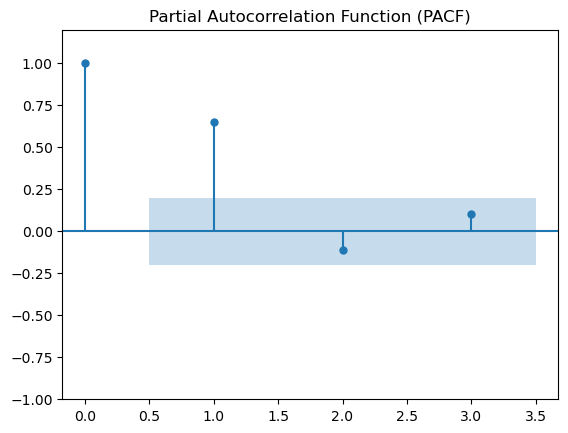

ADF Statistic: -4.366277347667877
p-value: 0.00034039067990094624
The process is stationary.


<Figure size 1400x600 with 0 Axes>

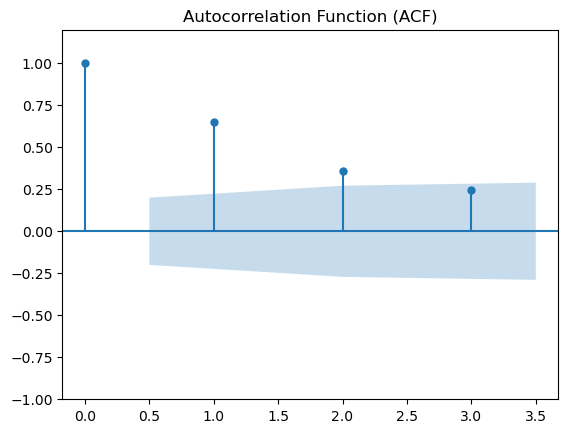

In [27]:
# Plot PACF - p

plt.figure(figsize=(14, 6))
plot_pacf(data_temp, lags=3)
plt.ylim(-1, 1.2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Check Stationary - d
# Augmented Dickey-Fuller test for stationarity

result = adfuller(data_temp)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

# Plot ACF - q

plt.figure(figsize=(14, 6))
plot_acf(data_temp, lags=3)
plt.ylim(-1, 1.2)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1400x600 with 0 Axes>

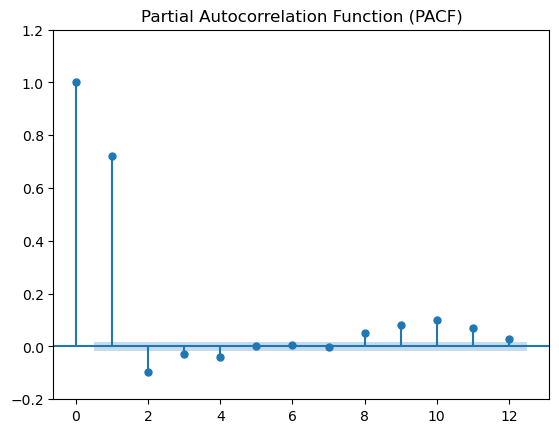

ADF Statistic: -12.001329493633243
p-value: 3.341240052097787e-22
The process is stationary.


<Figure size 1400x600 with 0 Axes>

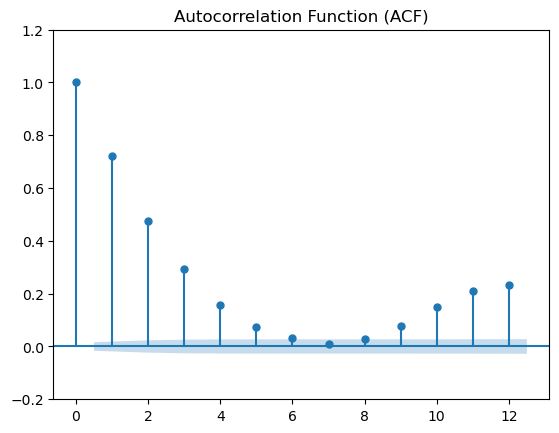

In [6]:
# Plot PACF - p

plt.figure(figsize=(14, 6))
plot_pacf(y_train, lags=12)
plt.ylim(-0.2, 1.2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Check Stationary - d
# Augmented Dickey-Fuller test for stationarity

result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

# Plot ACF - q

plt.figure(figsize=(14, 6))
plot_acf(y_train, lags=12)
plt.ylim(-0.2, 1.2)
plt.title('Autocorrelation Function (ACF)')
plt.show()

## Pre-processing

In [2]:
# Prediction
PREDICTION_TERM = 'Global_active_power'

# Graph
width = 14
height = 6

# Colors
coolwarm = cm.coolwarm
red = coolwarm(0.9)
blue = coolwarm(0.1)

In [3]:
# Load the CSV file
data = pd.read_csv('2yrs_data.csv')

# Drop unnecessary columns
data = data.drop(columns=['Global_reactive_power',
                          'Voltage', 'Global_intensity', 
                          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

# # Combine Date and Time to index
# data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# data.set_index('datetime', inplace=True)

# Convert to correct time format
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.strftime('%H:%M')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Create a time grid for first date (not starting at 00:00)
first_date = data['Date'].min()
first_time = data[data['Date'] == first_date]['Time'].min()
first_date_times = pd.date_range(start=first_time, end="23:59", freq='min').time
first_date_grid = pd.DataFrame(
    [(first_date, time) for time in first_date_times], 
    columns=['Date', 'Time']
)

# Create a time grid for all other dates (starting at 00:00)
other_dates = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')
other_date_times = pd.date_range(start="00:00", end="23:59", freq='min').time
other_dates_grid = pd.DataFrame(
    [(date, time) for date in other_dates[1:] for time in other_date_times],
    columns=['Date', 'Time']
)

# Combine both grids
full_grid = pd.concat([first_date_grid, other_dates_grid], ignore_index=True)
full_grid['Time'] = pd.to_datetime(full_grid['Time'], format='%H:%M:%S').dt.strftime('%H:%M')

# Reset data so that it includes missing time
data = full_grid.merge(data, on=['Date', 'Time'], how='outer').sort_values(by=['Date', 'Time']).reset_index(drop=True)

# # Impute the NaN 'is_holiday' based on the same day
# holiday_dates = data[data['is_holiday']==1]['Date'].to_list()
# holiday_dates = pd.to_datetime(holiday_dates).date
# data['is_holiday'] = data['Date'].isin(holiday_dates).astype(int)

# # Impute the NaN 'is_weekend' based on the same day
# data['Date'] = pd.to_datetime(data['Date'])
# data['is_weekend'] = (data['Date'].dt.weekday >= 5).astype(int)

## Data Analysis

In [4]:
missing_data = data[data[PREDICTION_TERM].isna()]
print(len(missing_data), len(data))
print(len(missing_data) / len(data)) # 0.3 percent of missing data

4070 1074636
0.003787328918815301


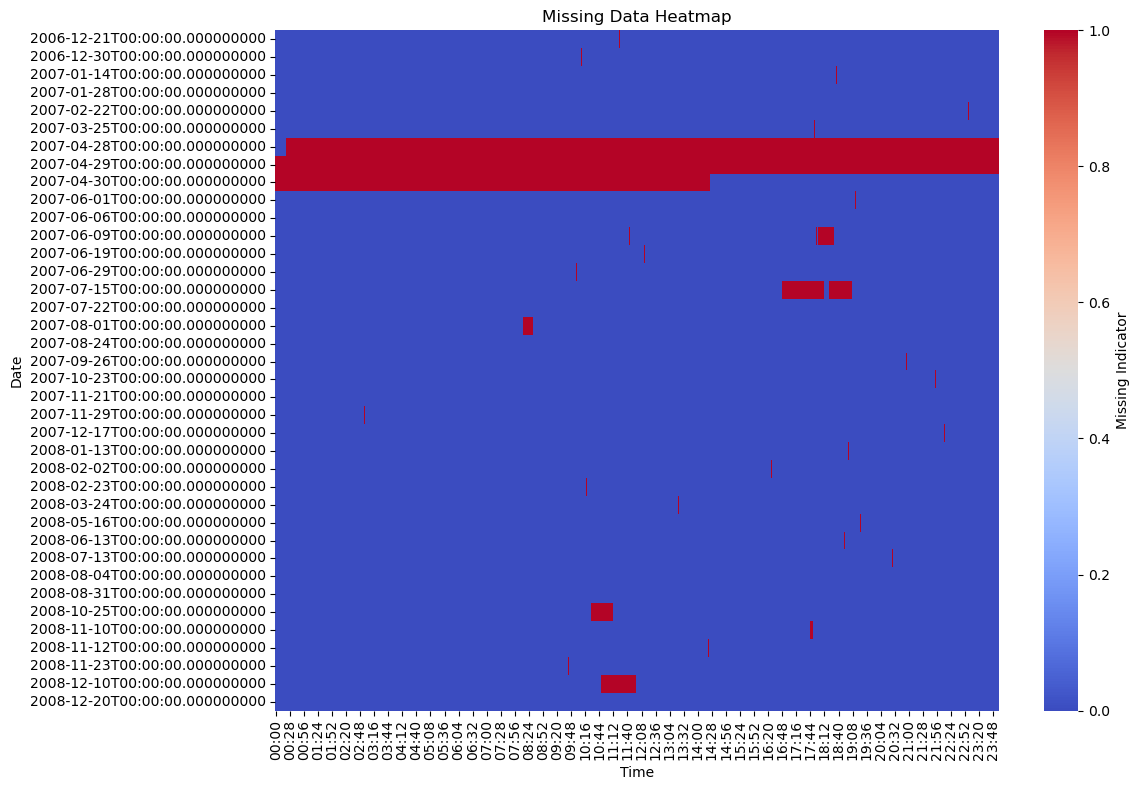

In [6]:
# Inspect missing values based on date time
heatmap_data = missing_data.pivot_table(index='Date', \
                                        columns='Time', values=PREDICTION_TERM, \
                                            aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Missing Indicator'})
plt.title('Missing Data Heatmap')
plt.ylabel('Date')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# What happened during 4/28/2007 to 5/01/2007 to this household?
# Political activity due to presidential election?

## Modeling

In [8]:
# ===== Reminder and Checks =====

# Display normal data
display(data.head(3))

# Display missing data
display(data[data[PREDICTION_TERM].isna()].head(3))

# Display earliest data
display(data.sort_values(by=['Date', 'Time'], ascending=True).head(3))

# Display latest data
display(data.sort_values(by=['Date', 'Time'], ascending=False).head(3))

,Date,Time,Global_active_power
0,2006-12-16,17:24,4.216
1,2006-12-16,17:25,5.360
2,2006-12-16,17:26,5.374


,Date,Time,Global_active_power
6839,2006-12-21,11:23,NaN
6840,2006-12-21,11:24,NaN
19724,2006-12-30,10:08,NaN


,Date,Time,Global_active_power
0,2006-12-16,17:24,4.216
1,2006-12-16,17:25,5.360
2,2006-12-16,17:26,5.374


,Date,Time,Global_active_power
1074635,2008-12-31,23:59,0.482
1074634,2008-12-31,23:58,0.480
1074633,2008-12-31,23:57,0.482


<Figure size 1400x600 with 0 Axes>

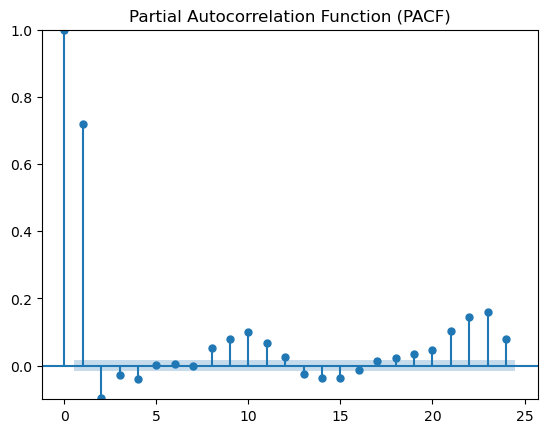

In [5]:
# Plot PACF - p

plt.figure(figsize=(14, 6))
plot_pacf(y_train, lags=24)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [6]:
# Check Stationary - d
# Augmented Dickey-Fuller test for stationarity

result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

ADF Statistic: -12.019614533359773
p-value: 3.045085599456562e-22
The process is stationary.


<Figure size 1400x600 with 0 Axes>

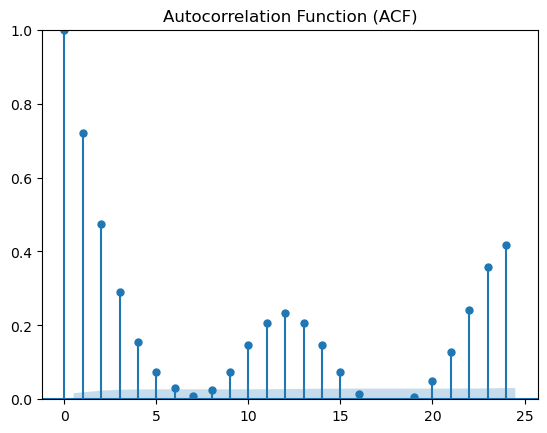

In [7]:
# Plot ACF - q

plt.figure(figsize=(14, 6))
plot_acf(y_train, lags=24)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1400x600 with 0 Axes>

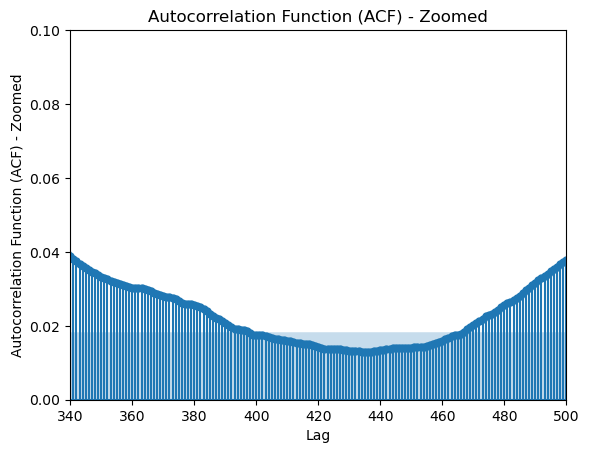

In [ ]:
# # Plot ACF with zoomed x-lim
# plt.figure(figsize=(width, height))
# plot_acf(data_temp[PREDICTION_TERM], lags=500)
# plt.xlim(340, 500)  # Set the x-limits to zoom in the specfic range of time local minima
# plt.ylim(0, 0.1)
# plt.title('Autocorrelation Function (ACF) - Zoomed')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation Function (ACF) - Zoomed')
# plt.show()

In [4]:
# Orders
# p = [3, 5, 7]
# d = 0
# q = 435

order = (5, 0, 435)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

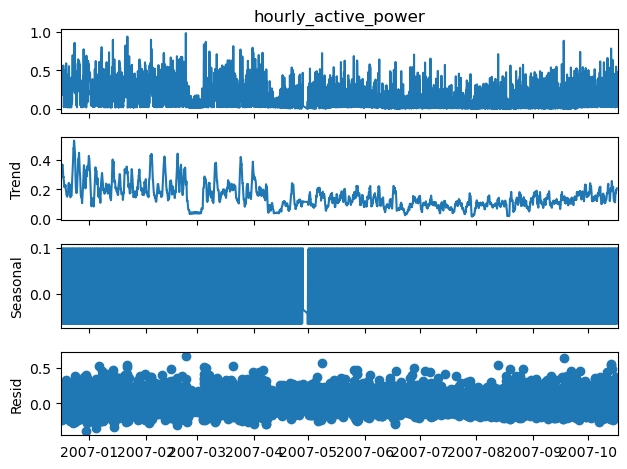

In [36]:
seasonality_check = seasonal_decompose(y_train, model='additive', period=24)
seasonality_check.plot()
plt.show()

In [38]:
seasonality_check.seasonal

DateTime
2006-12-16 17:00:00   -0.003623
2006-12-16 18:00:00    0.059726
2006-12-16 19:00:00    0.108660
2006-12-16 20:00:00    0.083358
2006-12-16 21:00:00    0.077511
                         ...   
2007-10-17 06:00:00   -0.055158
2007-10-17 07:00:00   -0.010223
2007-10-17 08:00:00    0.057806
2007-10-17 09:00:00    0.090429
2007-10-17 10:00:00    0.091844
Name: seasonal, Length: 7252, dtype: float64

## Data Processing

In [5]:
data['Timestamp'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))
data.set_index('Timestamp', inplace=True)  # Use the timestamp as the index

print(f"{data[PREDICTION_TERM].isna().sum()} NaN value remaining")
print(f"{len(data)} data in total")

4070 NaN value remaining
1074636 data in total


In [6]:
# Imputation: Last/Next year data

def year_based_imputation(df, col_name):
    df_copy = df.copy()
    for idx in df_copy[df_copy[col_name].isna()].index:  # Loop through missing values
        year = idx.year
        for offset in [-1, 1]:  # Check previous and next year
            new_year = year + offset
            try:
                candidate_index = idx.replace(year=new_year)
                if candidate_index in df_copy.index:
                    value = df_copy.at[candidate_index, col_name]
                    if not pd.isna(value):  # If valid value found, impute it
                        df_copy.at[idx, col_name] = value
                        break
            except ValueError:  # Handle invalid date replacements like 2/29 in non-leap years
                continue
                
    return df_copy

data_imputed1 = year_based_imputation(data, PREDICTION_TERM)
print(f"{data_imputed1[PREDICTION_TERM].isna().sum()} NaN value remaining")

0 NaN value remaining


<Figure size 1400x600 with 0 Axes>

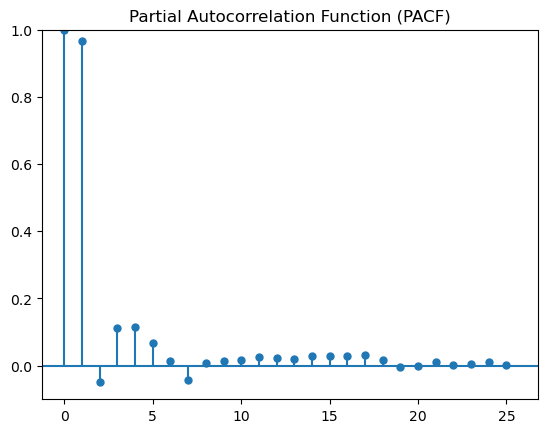

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_imputed1[PREDICTION_TERM], lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [7]:
# Imputation: Forward-Fill
data_imputed2 = data.copy(deep=True)
data_imputed2[PREDICTION_TERM] = data_imputed2[PREDICTION_TERM].ffill()

print(f"{data_imputed2.isna().sum()} NaN value remaining")

Date                   0
Time                   0
Global_active_power    0
dtype: int64 NaN value remaining


<Figure size 1400x600 with 0 Axes>

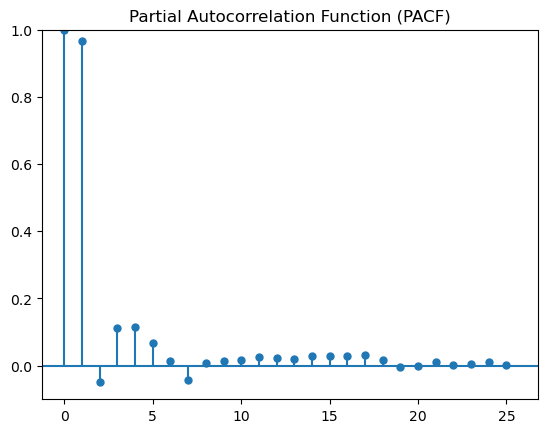

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_imputed2, lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [8]:
# Drop Missing Values

data_dropnan = data.dropna(subset=[PREDICTION_TERM])

print(f"{data_dropnan[PREDICTION_TERM].isna().sum()} NaN value remaining")

0 NaN value remaining


<Figure size 1400x600 with 0 Axes>

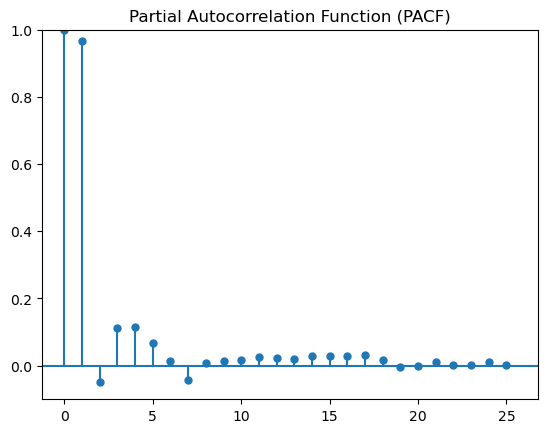

In [ ]:
# ===== Check if PACF Changes =====

plt.figure(figsize=(width, height))
plot_pacf(data_dropnan[PREDICTION_TERM], lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## ARIMA

### data_dropnan

<Figure size 1200x600 with 0 Axes>

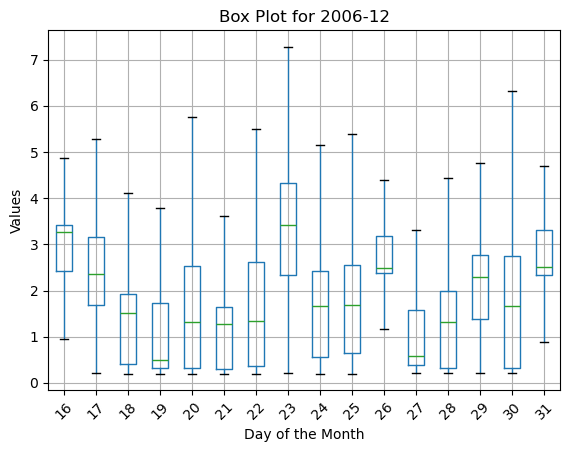

<Figure size 1200x600 with 0 Axes>

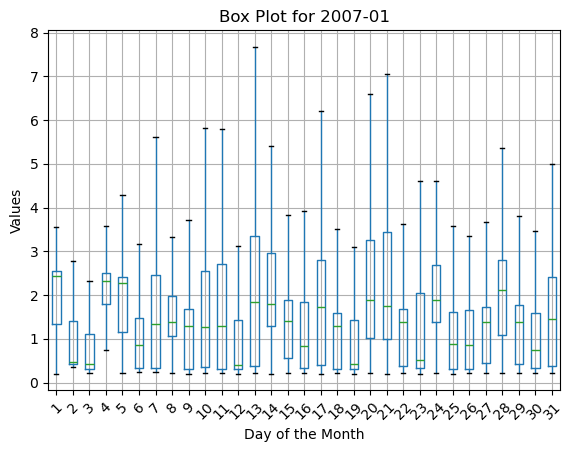

<Figure size 1200x600 with 0 Axes>

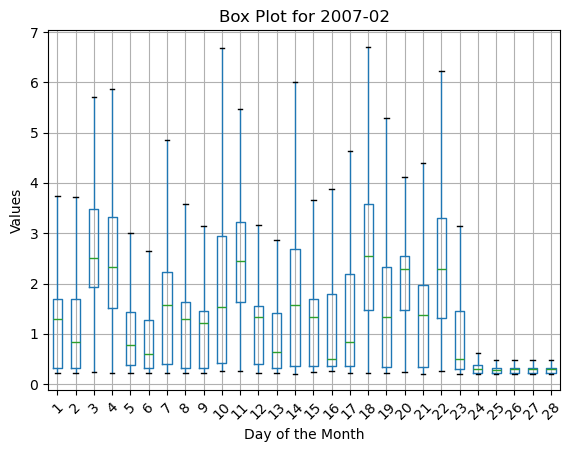

<Figure size 1200x600 with 0 Axes>

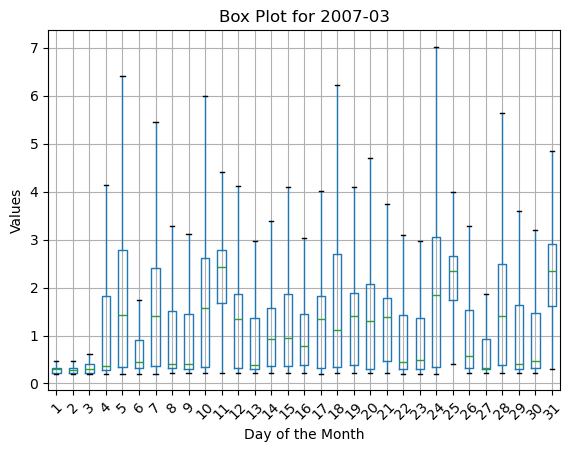

<Figure size 1200x600 with 0 Axes>

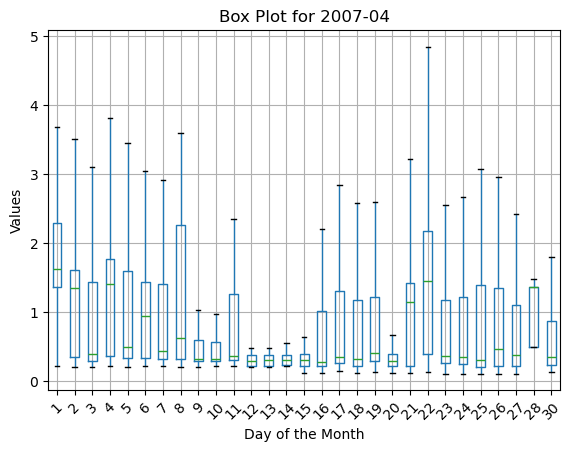

<Figure size 1200x600 with 0 Axes>

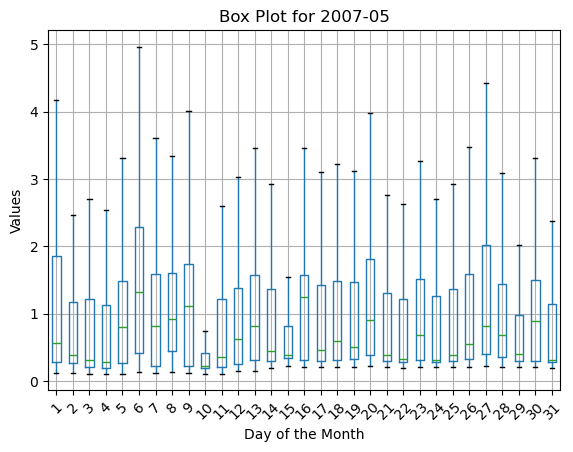

<Figure size 1200x600 with 0 Axes>

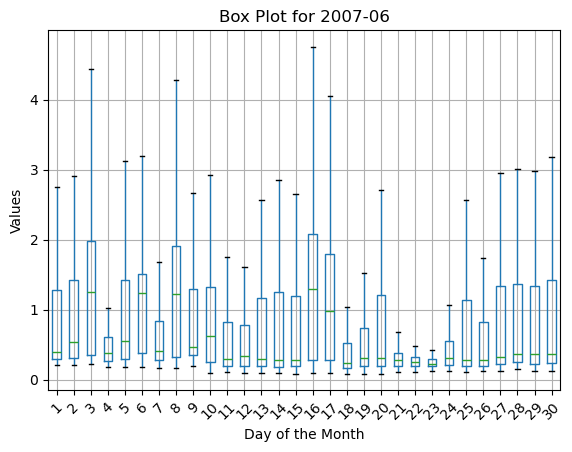

<Figure size 1200x600 with 0 Axes>

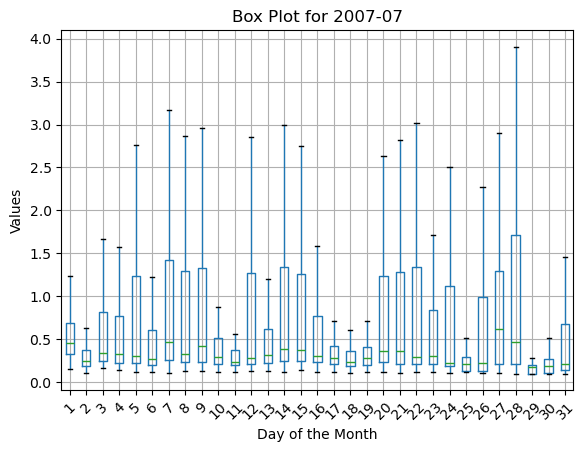

<Figure size 1200x600 with 0 Axes>

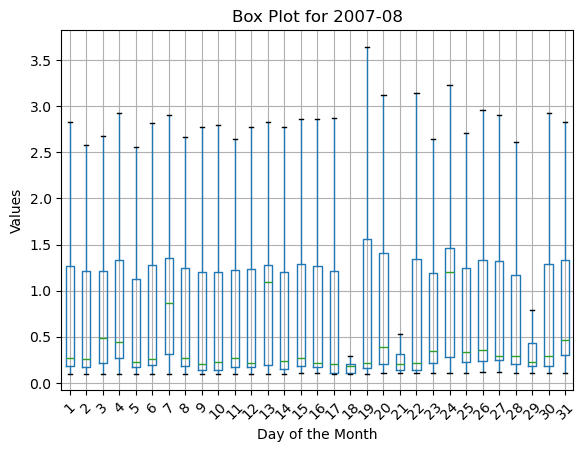

<Figure size 1200x600 with 0 Axes>

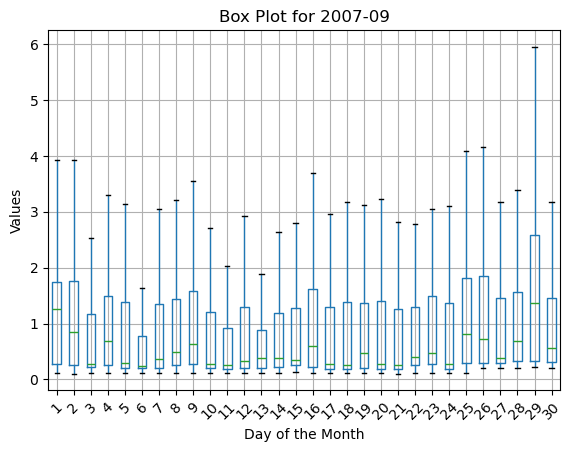

<Figure size 1200x600 with 0 Axes>

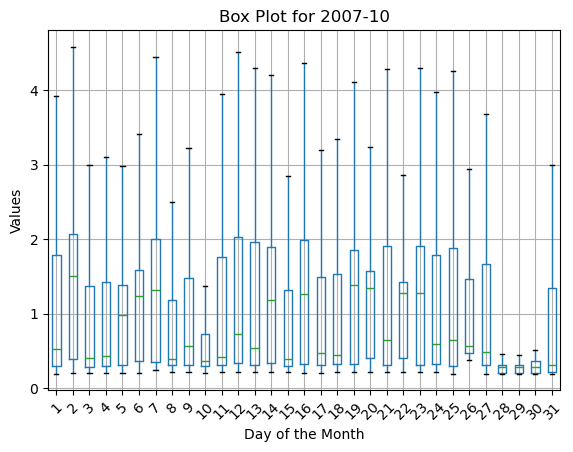

<Figure size 1200x600 with 0 Axes>

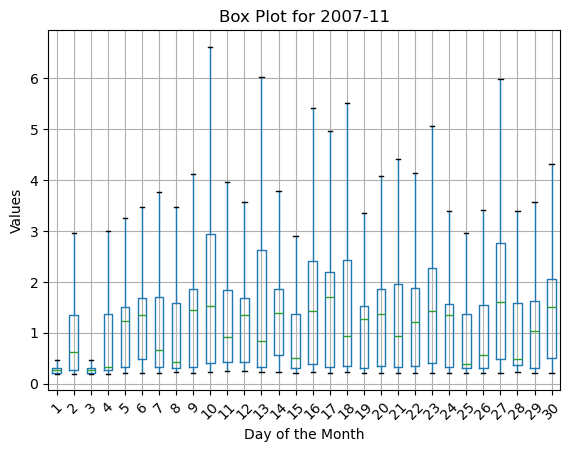

<Figure size 1200x600 with 0 Axes>

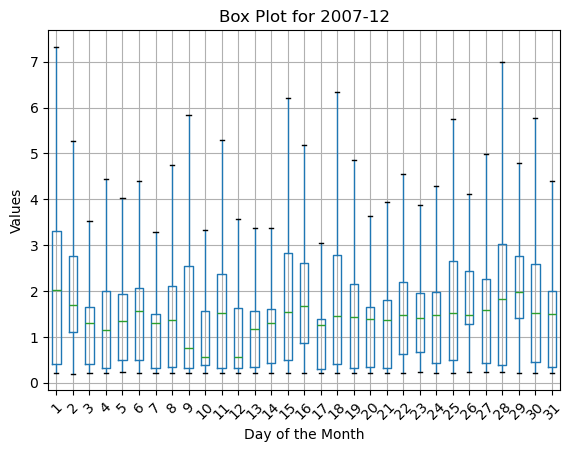

<Figure size 1200x600 with 0 Axes>

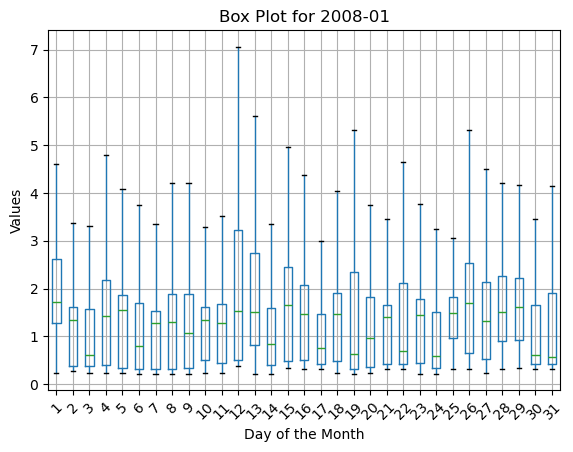

<Figure size 1200x600 with 0 Axes>

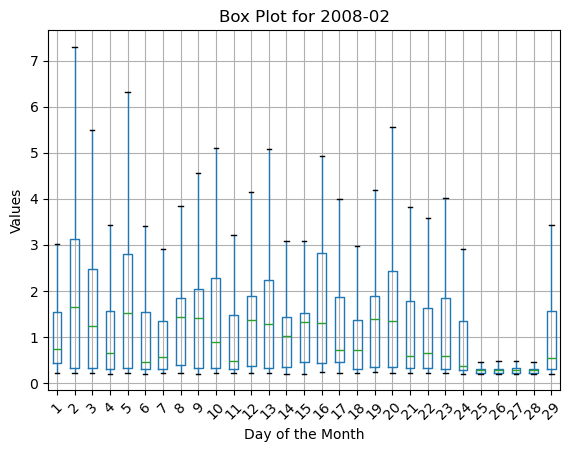

<Figure size 1200x600 with 0 Axes>

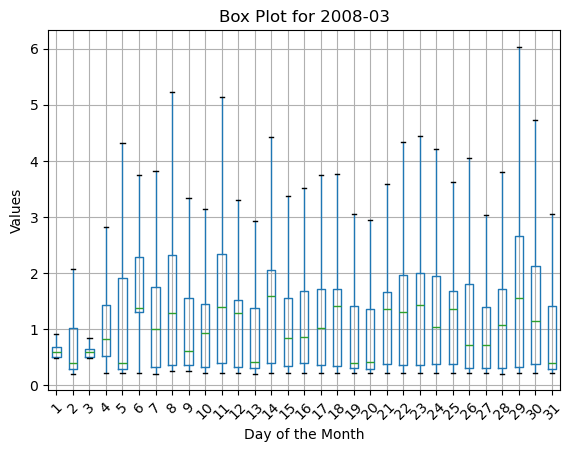

<Figure size 1200x600 with 0 Axes>

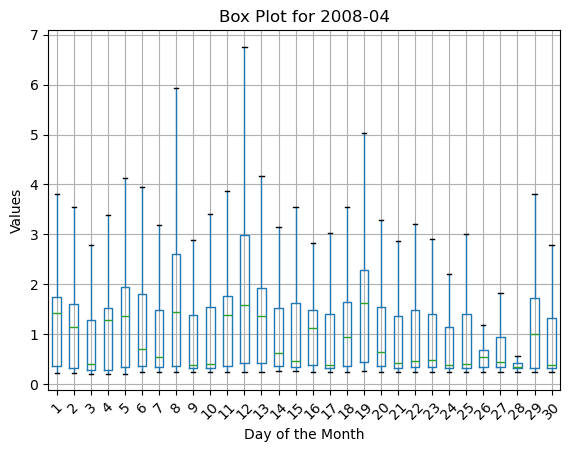

<Figure size 1200x600 with 0 Axes>

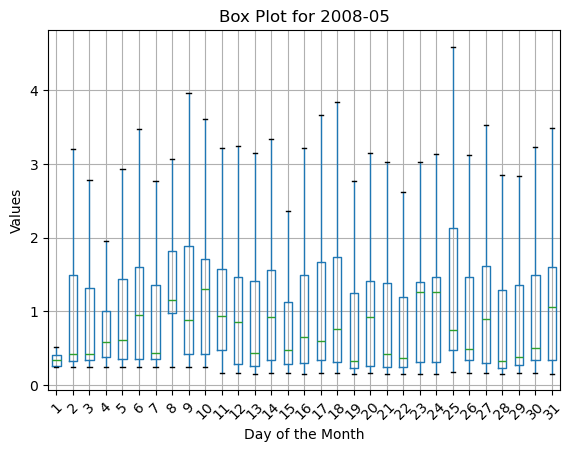

<Figure size 1200x600 with 0 Axes>

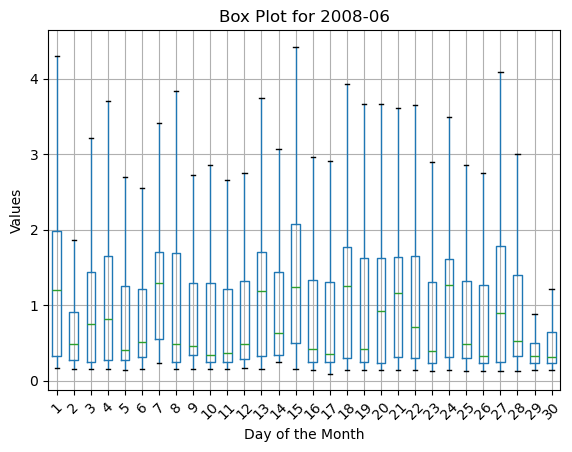

<Figure size 1200x600 with 0 Axes>

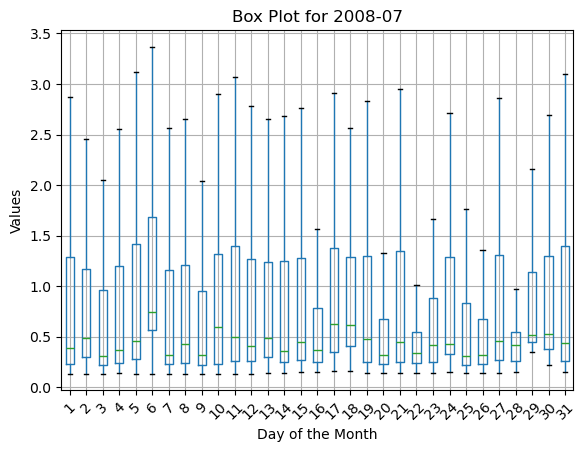

<Figure size 1200x600 with 0 Axes>

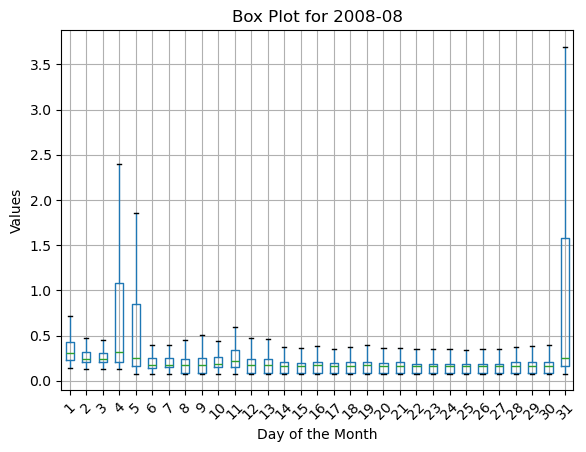

<Figure size 1200x600 with 0 Axes>

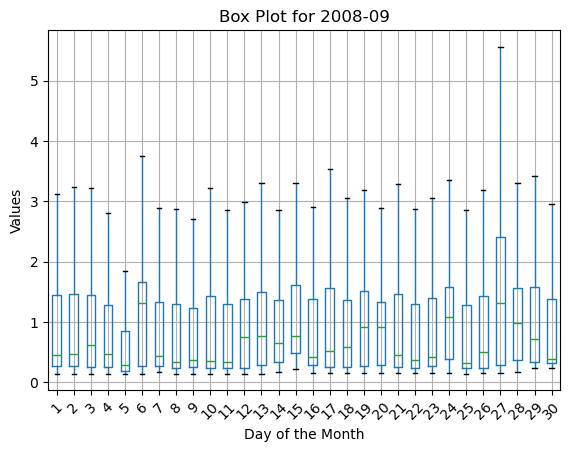

<Figure size 1200x600 with 0 Axes>

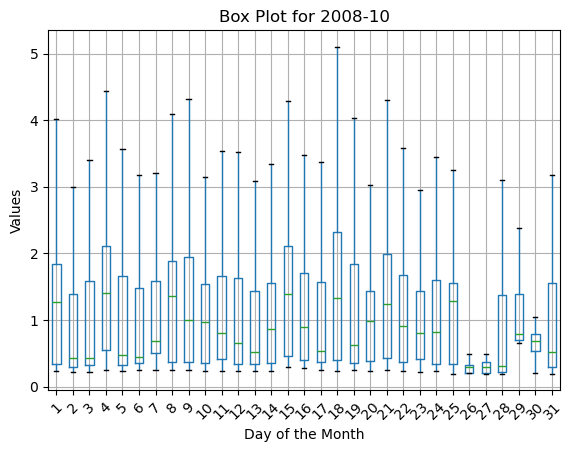

<Figure size 1200x600 with 0 Axes>

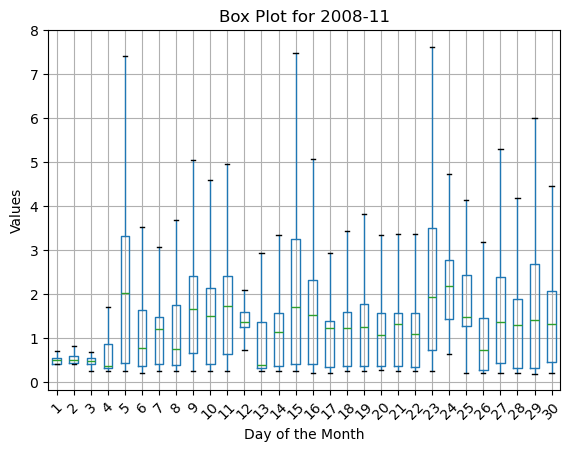

<Figure size 1200x600 with 0 Axes>

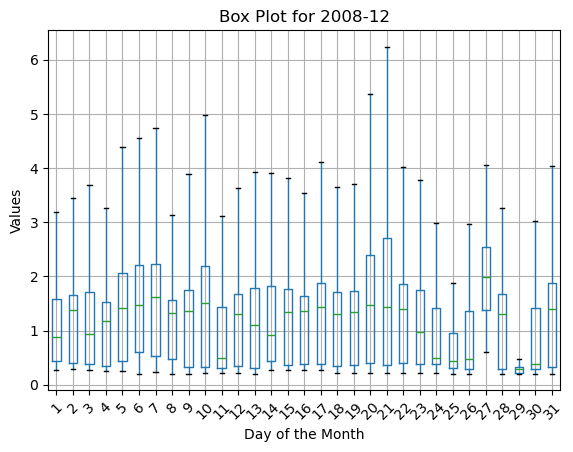

In [13]:
# Ensure 'Date' is a datetime object
data_dropnan['Date'] = pd.to_datetime(data_dropnan['Date'])

# Extract day and month for grouping
data_dropnan['Day'] = data_dropnan['Date'].dt.day
data_dropnan['MonthYear'] = data_dropnan['Date'].dt.to_period('M')  # Year-Month grouping

# Iterate through each unique Month-Year and plot
for month_year in data_dropnan['MonthYear'].unique():
    # Subset the data for the current Month-Year
    monthly_data = data_dropnan[data_dropnan['MonthYear'] == month_year]

    # Create the box plot for each day of the month
    plt.figure(figsize=(12, 6))
    monthly_data.boxplot(column=PREDICTION_TERM, by='Day', grid=False, showfliers=False)
    plt.title(f'Box Plot for {month_year}')
    plt.suptitle('')  # Removes default subtitle
    plt.xlabel('Day of the Month')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [20]:
data_dropnan['Date'] = pd.to_datetime(data_dropnan['Date'])
data_dropnan_median = data_dropnan.groupby(data_dropnan['Date'].dt.date)[PREDICTION_TERM].median()

data_dropnan_median.tail(3)

Date
2008-12-29    0.286
2008-12-30    0.374
2008-12-31    1.407
Name: Global_active_power, dtype: float64

<Figure size 1400x600 with 0 Axes>

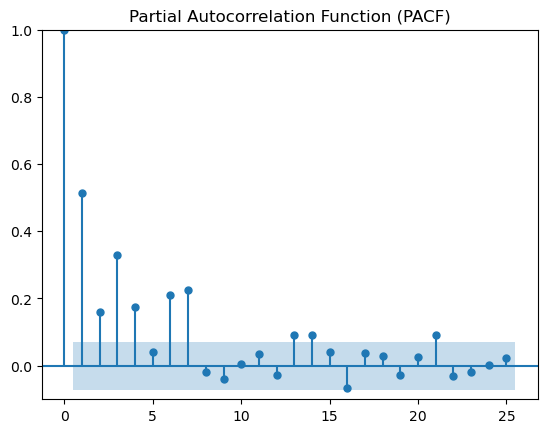

ADF Statistic: -2.9375537413245416
p-value: 0.041152055775579295
The process is stationary.


<Figure size 1400x600 with 0 Axes>

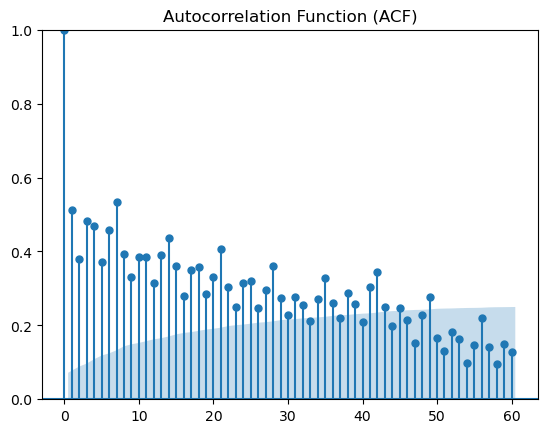

In [25]:
# Plot PACF - p
plt.figure(figsize=(width, height))
plot_pacf(data_dropnan_median, lags=25)
plt.ylim(-0.1, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Check Stationary - d
result = adfuller(data_dropnan_median)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The process is stationary.")
else:
    print("The process is not stationary.")

# Plot ACF - q
plt.figure(figsize=(width, height))
plot_acf(data_dropnan_median, lags=60)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [37]:
# Train-Test Split
def train_test_split(series, split_ratio=0.8):
    split_index = int(len(series) * split_ratio)
    train, test = series[:split_index], series[split_index:]
    return train, test

In [42]:
# Evaluate ARIMA
def evaluate_arima(train, test, order):
    """
    Fits an ARIMA model and calculates RMSE, MAE, and Accuracy.

    Args:
    - train: Training data (Pandas Series or NumPy array).
    - test: Testing data (Pandas Series or NumPy array).
    - order: ARIMA order tuple (p, d, q).

    Returns:
    - rmse: Root Mean Squared Error.
    - mae: Mean Absolute Error.
    - accuracy: Forecast accuracy as a percentage.
    """
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast for the test set
    forecast = model_fit.forecast(steps=len(test))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    # Define accuracy as the percentage of forecasts within 5% of the actual value
    accuracy = np.mean(np.isclose(test, forecast, atol=0.05 * np.abs(test))) * 100

    return rmse, mae, accuracy

# Example Usage
# Assuming `data_dropnan_median` is a Pandas Series
train, test = train_test_split(data_dropnan_median)

# Define ARIMA order (adjust based on ACF/PACF analysis)
arima_order = (7, 0, 30)

# Evaluate the model
rmse, mae, accuracy = evaluate_arima(train, test, arima_order)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

RMSE: 0.5761
MAE: 0.4439
Accuracy: 8.00%


/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### data_imputed1

### data_imputed2